In [ ]:
import pandas as pd

# Load the dataset
file_path = "IMDB Dataset.csv"
df = pd.read_csv(file_path)

# Display first few rows to verify
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df = df.drop('sentiment', axis=1)

# Display first few rows to verify
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training (70%), validation (15%), and testing (15%)
train_data, temp_data = train_test_split(df, test_size=0.7, random_state=42)  # 70% training
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% validation, 15% test

# Display dataset sizes
print(f"Training data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")
print(f"Testing data: {len(test_data)}")

# Show first few rows of training data
print(train_data.head())

Training data: 15000
Validation data: 17500
Testing data: 17500
                                                  review  label
45139  The Fiendish Plot of Dr. Fu Manchu (1980). Thi...      0
9901   If ever I was asked to remember a song from a ...      1
26038  This is a catastrophe movie set in London . St...      1
49163  The Return is one of those movies for that nic...      0
38957  the worst sequel I've ever seen. really awful ...      0


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset, DatasetDict # Import DatasetDict


# Step 3: Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Step 4: Tokenize the Dataset
def preprocess(examples):
    return tokenizer(examples["review"], truncation=True, padding="max_length", max_length=256)

# Convert pandas DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)


# Apply tokenization using the 'map' function from the 'datasets' library
train_data_t = train_dataset.map(preprocess, batched=True)
val_data_t = val_dataset.map(preprocess, batched=True)
test_data_t = test_dataset.map(preprocess, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

In [ ]:
# Step 5: Load Pre-trained Model
# Load a pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",             # Directory to save results and model checkpoints
    eval_strategy="epoch",       # Evaluate the model at the end of each epoch
    learning_rate=5e-5,                # Optimizer learning rate
    per_device_train_batch_size=16,     # Batch size for each GPU or CPU
    num_train_epochs=2,                # Number of training epochs
    logging_dir='./logs',              # Directory for logging
    logging_steps=10,                  # Log every 10 steps
)

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,                        # The pre-trained model to fine-tune
    args=training_args,                 # Training arguments
    train_dataset=train_data_t,  # Training dataset
    eval_dataset=val_data_t,    # Evaluation dataset
)

# Step 8: Train the Model
trainer.train()

# Step 9: Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jopohjo (jopohjo-tampere-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.343600,0.242924
2,0.174300,0.310485


Evaluation Results: {'eval_loss': 0.3104851543903351, 'eval_runtime': 134.1703, 'eval_samples_per_second': 130.431, 'eval_steps_per_second': 16.308, 'epoch': 2.0}


In [ ]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./imdb-finetuned-model")
tokenizer.save_pretrained("./imdb-finetuned-model")

('./imdb-finetuned-model/tokenizer_config.json',
 './imdb-finetuned-model/special_tokens_map.json',
 './imdb-finetuned-model/vocab.txt',
 './imdb-finetuned-model/added_tokens.json',
 './imdb-finetuned-model/tokenizer.json')

In [ ]:
from huggingface_hub import notebook_login

# Log in to Hugging Face
notebook_login()


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Reload the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./imdb-finetuned-model")
tokenizer = AutoTokenizer.from_pretrained("./imdb-finetuned-model")

# Upload to Hugging Face Hub
model.push_to_hub("jopohjo/imdb-finetuned-model")
tokenizer.push_to_hub("jopohjo/imdb-finetuned-model")



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jopohjo/imdb-finetuned-model/commit/414412fc1a5cc517072257a224aab563c76b5d9c', commit_message='Upload tokenizer', commit_description='', oid='414412fc1a5cc517072257a224aab563c76b5d9c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jopohjo/imdb-finetuned-model', endpoint='https://huggingface.co', repo_type='model', repo_id='jopohjo/imdb-finetuned-model'), pr_revision=None, pr_num=None)

https://huggingface.co/jopohjo/imdb-finetuned-model

In [ ]:
!pip install fastapi uvicorn transformers torch

In [ ]:
!pip install requests
!pip install fastapi uvicorn nest-asyncio pyngrok transformers torch requests

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import requests
from transformers import pipeline
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Apply nest_asyncio to avoid runtime errors in Colab
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

# Load your custom fine-tuned model from Hugging Face
custom_model_name = "jopohjo/imdb-finetuned-model"
custom_classifier = pipeline("text-classification", model=custom_model_name)

# Groq Cloud API details for Llama 3
GROQ_API_KEY = "token_here"
GROQ_ENDPOINT = "https://api.groq.com/v1/chat/completions"

# Define request model
class SentimentRequest(BaseModel):
    text: str
    model: str  # "custom" or "llama"

# Function to analyze sentiment using Llama 3 via Groq API
def analyze_with_groq(text):
    headers = {"Authorization": f"Bearer {GROQ_API_KEY}", "Content-Type": "application/json"}
    payload = {
        "model": "llama3-8b",
        "messages": [{"role": "user", "content": f"Analyze sentiment: {text}"}],
        "temperature": 0.2
    }
    response = requests.post(GROQ_ENDPOINT, headers=headers, json=payload)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return "Error: Unable to process request"

# Define POST endpoint for sentiment analysis
@app.post("/analyze/")
async def analyze_sentiment(request: SentimentRequest):
    if request.model == "custom":
        # Use custom fine-tuned model
        result = custom_classifier(request.text)[0]
        return {
            "sentiment": result["label"],  # "POSITIVE" or "NEGATIVE"
            "confidence": round(result["score"], 4)
        }

    elif request.model == "llama":
        # Use Llama 3 via Groq API
        sentiment_result = analyze_with_groq(request.text)
        return {"sentiment": sentiment_result}

    else:
        return {"error": "Invalid model. Choose 'custom' or 'llama'."}


Device set to use cuda:0


In [ ]:
!ngrok config add-authtoken insert_token_here

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Start ngrok to expose the FastAPI app
public_url = ngrok.connect(8000).public_url
print(f"FastAPI is running on {public_url}")

# Start the FastAPI app
uvicorn.run(app, host="0.0.0.0", port=8000)


FastAPI is running on https://a6d3-34-142-240-28.ngrok-free.app


INFO:     Started server process [402]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     84.231.189.68:0 - "POST / HTTP/1.1" 404 Not Found
INFO:     84.231.189.68:0 - "POST /?text=This%20movie%20was%20fantastic!%22&model=custom HTTP/1.1" 404 Not Found
INFO:     84.231.189.68:0 - "POST / HTTP/1.1" 404 Not Found
INFO:     84.231.189.68:0 - "POST /analyze HTTP/1.1" 307 Temporary Redirect
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze HTTP/1.1" 307 Temporary Redirect
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze HTTP/1.1" 307 Temporary Redirect
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/?text=%22This%20movie%20was%20fantastic!%22&model=custom HTTP/1.1" 422 Unprocessable Entity


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se

INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 422 Unprocessable Entity
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     84.231.189.68:0 - "POST /analyze/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [402]


```
POST https://c514-34-142-240-28.ngrok-free.app/analyze/
{
    "text": "This movie was fantastic!",
    "model": "custom"
}

RETURN
{
    "sentiment": "LABEL_1",
    "confidence": 0.9962
}

```



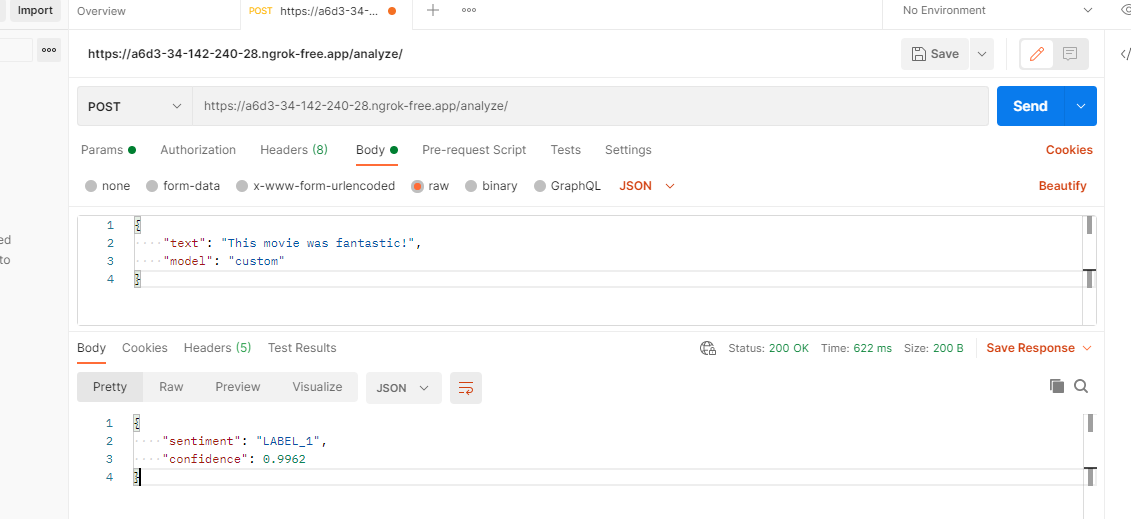

In [ ]:
npx create-react-app sentiment-analysis-app
cd sentiment-analysis-app

npm install axios

import React, { useState } from "react";
import axios from "axios";

function App() {
  // State variables
  const [text, setText] = useState("");
  const [model, setModel] = useState("custom");
  const [sentiment, setSentiment] = useState(null);
  const [confidence, setConfidence] = useState(null);

  // Handle input text change
  const handleTextChange = (event) => {
    setText(event.target.value);
  };

  // Handle model selection change
  const handleModelChange = (event) => {
    setModel(event.target.value);
  };

  // Call the API when the button is clicked
  const analyzeSentiment = async () => {
    try {
      // API URL (replace with your ngrok or server URL)
      const API_URL = "https://a6d3-34-142-240-28.ngrok-free.app/analyze/";

      const response = await axios.post(API_URL, {
        text: text,
        model: model,
      });

      // Set sentiment and confidence in the state
      setSentiment(response.data.sentiment);
      setConfidence(response.data.confidence || "N/A");
    } catch (error) {
      console.error("Error analyzing sentiment:", error);
    }
  };

  return (
    <div className="App">
      <h1>Sentiment Analysis</h1>

      {/* Text Input */}
      <div>
        <textarea
          value={text}
          onChange={handleTextChange}
          placeholder="Enter text to analyze"
        />
      </div>

      {/* Model Selection */}
      <div>
        <label>Select Model:</label>
        <select value={model} onChange={handleModelChange}>
          <option value="custom">Custom Model</option>
          <option value="llama">Llama 3</option>
        </select>
      </div>

      {/* Analyze Button */}
      <div>
        <button onClick={analyzeSentiment}>Analyze Sentiment</button>
      </div>

      {/* Result Section */}
      <div>
        {sentiment && (
          <div>
            <h2>Sentiment: {sentiment}</h2>
            {confidence !== "N/A" && (
              <p>Confidence: {confidence}</p>
            )}
          </div>
        )}
      </div>
    </div>
  );
}

export default App;


https://github.com/jopohjo/LLMWeek3